In [1]:
#| hide
from diffusion_curvature.datasets import *
from diffusion_curvature.kernels import *
from nbdev import show_doc

# Diffusion Curvature

> Fast, pointwise graph curvature

Diffusion curvature is a pointwise extension of Ollivier-Ricci curvature, designed specifically for the often messy world of pointcloud data.
Its advantages include:

1. Unaffected by density fluctuations in data: it inherits the diffusion operator's denoising properties.
2. Fast, and scalable to millions of points: it depends only on matrix powering - no optimal transport required.

## Install

It's not yet available via PyPI. In the meantime, you can run:

```sh
pip install git+git://github.com/professorwug/diffusion_curvature@master
```

## Usage

To compute diffusion curvature, first create a `graphtools` graph with your data. Graphtools offers extensive support for different kernel types (if creating from a pointcloud), and can also work with graphs in the `PyGSP` format. We recommend using `anistropy=1`, and verifying that the supplied knn value encompasses a reasonable portion of the graph.

In [2]:
from diffusion_curvature.datasets import torus
import graphtools
X_torus, torus_gaussian_curvature = torus(n=5000)
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=30)

Next, instantiate a `DiffusionCurvature` operator. 

In [3]:
from diffusion_curvature.graphtools import DiffusionCurvature
DC = DiffusionCurvature(t=12)

In [4]:
show_doc(DiffusionCurvature)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/master/diffusion_curvature/graphtools.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature

>      DiffusionCurvature (t:int, distance_type='PHATE', use_entropy:bool=False,
>                          **kwargs)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| t | int |  | Number of diffusion steps to use when measuring curvature. TODO: Heuristics |
| distance_type | str | PHATE |  |
| use_entropy | bool | False | If true, uses KL Divergence instead of Wasserstein Distances. Faster, seems empirically as good, but less proven. |
| kwargs |  |  |  |

And, finally, pass your graph through it. The `DiffusionCurvature` operator will store everything it computes -- the powered diffusion matrix, the estimated manifold distances, and the curvatures -- as attributes of your graph.
To get the curvatures, you can run `G.ks`.


In [5]:
G_torus = DC.curvature(G_torus, dimension=2)

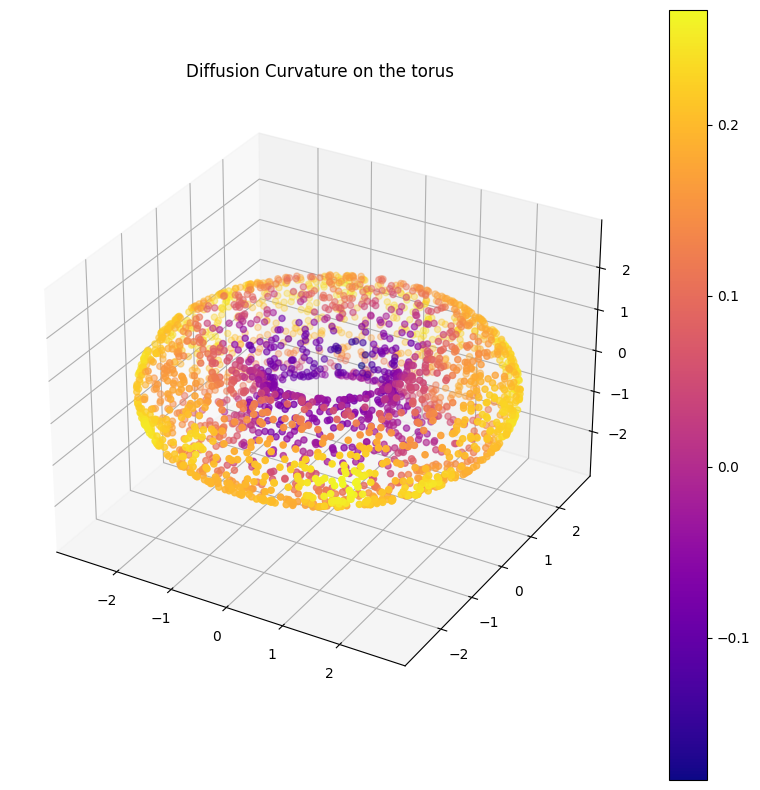

In [8]:
plot_3d(X_torus, G_torus.ks, colorbar=True, title="Diffusion Curvature on the torus")